# FORCAST Grism Spectra: Basic Line Analysis


## Introduction

This recipe provides an overview and sample code (in Python) for some simple line analysis tasks using FORCAST grism observations.  We recommend that the user reviews the first FORCAST Grism Recipe ([FORCAST Grism Recipe: Basic Inspection and Assessment](https://github.com/SOFIAObservatory/Recipes/blob/master/FORCAST-Grism_Inspection.ipynb)) before proceeding with this slightly more advanced tutorial.  

Raw FORCAST data suffers from several instrumental artifacts.  Nearly all of the artifacts are removed or corrected by the FORCAST pipeline, including: bad pixels; the Droop effect; non-linear pixel response; and the “jailbar” effect.  In addition, the grism pipeline extracts the one-dimensional spectra, applies both wavelength and flux calibration, and corrects for telluric absorption.   For point sources, an "optimal extraction" algorithm is used, while for extended (non-pointlike) sources, a standard summation over a manually defined aperture is used.  See the [FORCAST GO Data Handbook](https://www.sofia.usra.edu/sites/default/files/USpot_DCS_DPS/Documents/FORCAST_GO_HAndbook_RevC.pdf) for details regarding the artifacts, pipeline algorithms, and the flux-calibration process.  

In this recipe we show the user how to do some minor "cleaning" of the LEVEL_3 data and then some basic emission line analysis including continuum fitting and subtraction, line measurements, and simple line fitting. 


There are a handful of relatively mature spectral line analysis in python, including linetools and pyspeckit.  For this recipe/example, we are using specutils since this seems to be the most general package.  

## Ingredients

1. Level 3 (flux calibrated) FORCAST grism data (either CAL or CMB files) from the [SOFIA DCS Archive](https://dcs.arc.nasa.gov/dataRetrieval/SearchScienceArchiveInfoBasic.jsp).
2.  Sample Data (if desired):  In this example we will be using observations of the PN NGC 7009.  
    - Level 3 data can be obtained from the DCS Archive using the following search criteria (under Advanced Search):
        - MissionID = "2017-08-07_FO_F428"
        - Instrument/Config = "FORCAST/Grism"
        - Processing State = "LEVEL_3" 
        - Target = "NGC 7009" 
      Download all data and save to local desktop. 
    - For this example we will be using the following files:  
        - F0428_FO_GRI_0500637_FORG111_CAL_0177-0196.fits
        - F0428_FO_GRI_0500638_FORG227_CMB_0197-0215.fits
      For convenience, we recommend saving both files in a folder called "forcast-sample-data" in the same directory as this Python Notebook.
3. [FORCAST GO Data Handbook](https://www.sofia.usra.edu/sites/default/files/USpot_DCS_DPS/Documents/FORCAST_GO_HAndbook_RevC.pdf) for reference (latest version can be found on the [SOFIA Data Products and Archives page](https://www.sofia.usra.edu/science/proposing-and-observing/data-products/data-resources))
4. Download and install specutils from the [AstroPy Affiliated Packages](http://www.astropy.org/affiliated/index.html) page

## Cleaning the Data

First we'll load the calibrated data for a single grism observation (G111 in this example) and take a look at the spectrum.

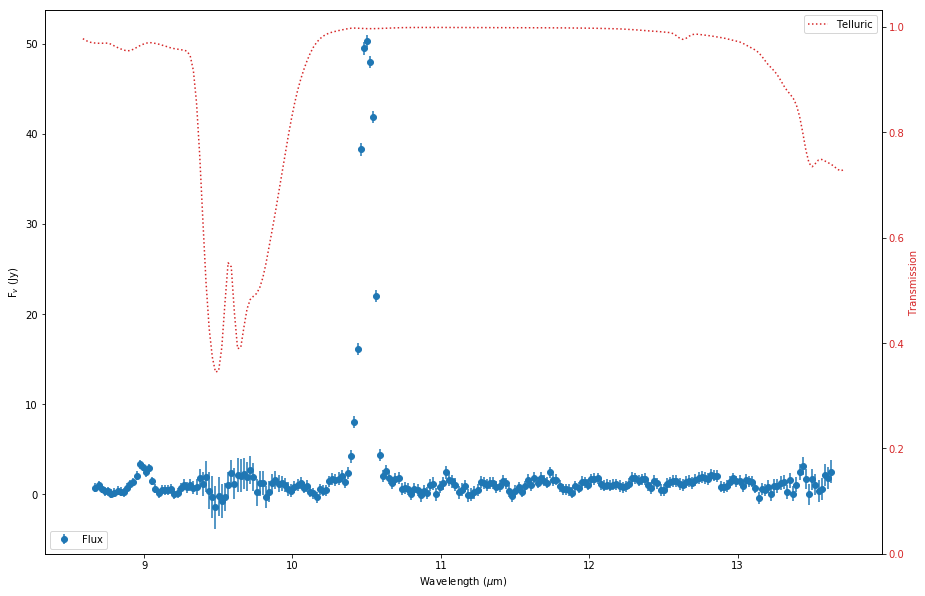

In [1]:
from astropy.io import fits
from astropy.table import Column
from astropy.table import Table,QTable
from astropy import constants as const
from astropy import units as u
from astropy.visualization import quantity_support
import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np
import numpy.ma as ma

quantity_support() 

#Define a function for loading fits data into table structure,
#keeping the FITS data for later use if needed.
def loadFORCASTGrismData(filename):
    #Now open fits file for the sample data...
    data_fits = fits.open(filename)

    #... read the data portion of the file into a separate array:
    data_tmp = data_fits[0].data

    #... load into table for convenience
    data_table = Table([data_tmp[0],data_tmp[1],data_tmp[2],data_tmp[3],data_tmp[4]], 
                  names=('wavelength', 'flux', 'error', 'telluric', 'response'), masked = True,
                  meta={'name': 'Data Table'})

    #and assign units.
    data_table['wavelength'].unit = 'micron'
    data_table['flux'].unit = 'Jy'
    data_table['error'].unit = 'Jy'
    data_table['response'].unit = 'Jy/s'
    
    return data_fits,data_table


#Calibrated data file on local disk:
calfile = 'forcast-sample-data/F0428_FO_GRI_0500637_FORG111_CAL_0177-0196.fits'

#Load fits data and tabular data...
g111_fits, g111_tab=loadFORCASTGrismData(calfile)

#And plot flux and telluric spectra
fig, ax1 = plt.subplots(figsize=(15,10))

ax1.set_xlabel('Wavelength ($\mu$m)')
ax1.set_ylabel('F$_v$ (Jy)')
ax1.errorbar(g111_tab['wavelength'],g111_tab['flux'],yerr=g111_tab['error'],fmt='o',label="Flux")
ax1.legend(loc="lower left")

color = 'tab:red'
ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
ax2.set_ylabel('Transmission', color=color)
ax2.plot(g111_tab['wavelength'],g111_tab['telluric'], color=color, linestyle=':',label="Telluric")
ax2.tick_params(axis='y', labelcolor=color)
ax2.set_ylim(bottom=0.0)
ax2.legend()

There are two main issues we need to "clean" before proceeding with line analysis:  NaN values and noisy data due to deep telluric features.  We'll define a function for this that creates a mask and then uses it to create a new "clean"-ed table of wavelength, flux, and error (leaving the telluric and response sprectra behind).

Text(0,0.5,'F$_v$ (Jy)')

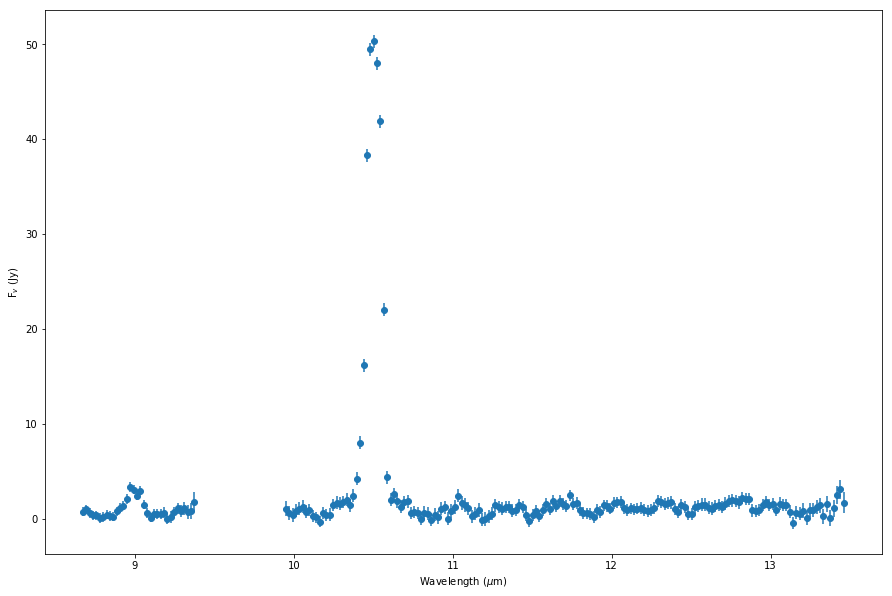

In [2]:
#Define a "clean"-ing function, that takes a FORCAST data table and telluric threshold as inputs:
def cleanFORCASTGrismData(in_table,tell_thresh):
    #Now define mask:
    in_table['flux'].mask  = (in_table['telluric'] < tell_thresh) | np.isnan(in_table['flux'])

    #and apply it to the wavelength, flux, and error arrays
    fc = in_table['flux'][~in_table['flux'].mask]
    wc = in_table['wavelength'][~in_table['flux'].mask]
    fc_err = in_table['error'][~in_table['flux'].mask]

    #and return a new table with cleaned arrays
    #Need to use QTable here to support specutils later.
    return QTable([wc,fc,fc_err], 
                  names=('wavelength', 'flux', 'error'), masked = True,
                  meta={'name': 'Cleaned Spectrum'})


#and now execute on our data for G111 with a telluric threshold of 0.75
g111_clean = cleanFORCASTGrismData(g111_tab,0.75)

#And plot flux and errors
plt.figure(figsize=(15,10))
plt.errorbar(g111_clean['wavelength'],g111_clean['flux'],yerr=g111_clean['error'],fmt='o',label="Flux")
#plt.legend(loc="lower left")
plt.xlabel('Wavelength ($\mu$m)')
plt.ylabel('F$_v$ (Jy)')


Now that the spectrum is cleaned, we are ready to begin some simple line analysis.

## Fitting the Continuum Across the Grism

Our first analysis task is to fit the continuum across the grism.  In this step, the hard part is really identifying all the sections for "line-free" continuum.  There are many ways to do this automatically:  in this example we will simply estimate the continuum regions by eye. The easiest way to bookkeep this is to identify all the regions with lines first, then logically invert those regions to extract the continuum.  In the G111 case above, we have two lines:  one at ~9.0 $\mu$m and another stronger one at ~10.5 $\mu$m.  So lets define our line regions as:
- 8.88 -- 9.15 $\mu$m
- 10.25 -- 10.75 $\mu$m

In [3]:
#As usual, lets define a function that takes a list of *clean* line regions and extracts the continuum spectum:
def createContinuumSpectrum(in_table,line_regions):
    wave = in_table['wavelength']
    flux = in_table['flux']
    err = in_table['error']
    
    #initialize the continuum mask
    cont_mask = 1.0*u.um < wave
    for x in line_regions:
        cont_mask = cont_mask & ~((x[0]<wave) & (x[1]>wave))

    return  QTable([wave[cont_mask],flux[cont_mask],err[cont_mask]], 
                  names=('wavelength', 'flux', 'error'), masked = True,
                  meta={'name': 'Continuum Spectrum'})



Text(0,0.5,'F$_v$ (Jy)')

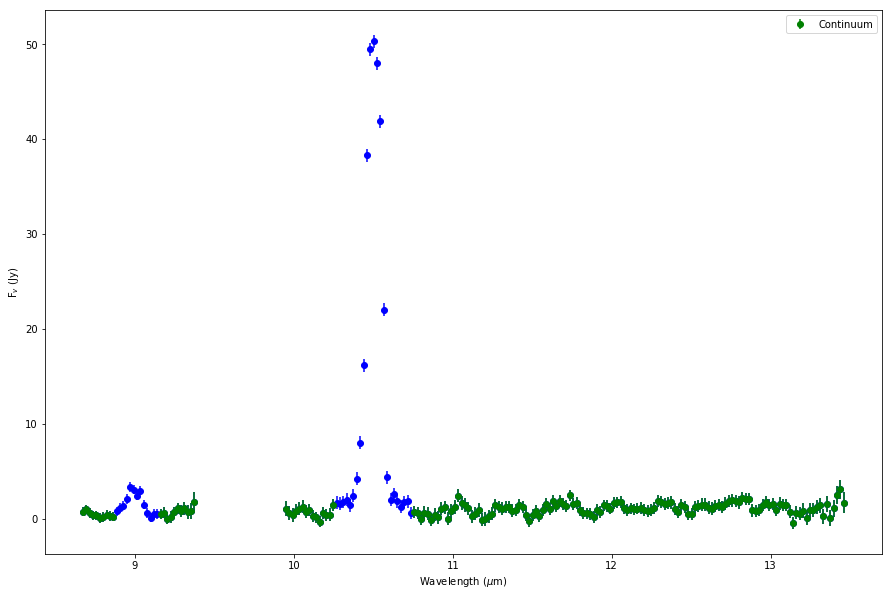

In [4]:
#now try it out with our G111 data
#first defint the line regions...
g111_line_regions = [[8.88*u.um,9.15*u.um], 
                [10.25*u.um,10.75*u.um]]

g111_cont = createContinuumSpectrum(g111_clean,g111_line_regions)

#And plot flux and errors with continuum in green
plt.figure(figsize=(15,10))
plt.errorbar(g111_clean['wavelength'],g111_clean['flux'],yerr=g111_clean['error'],fmt='o',color='b')
plt.errorbar(g111_cont['wavelength'],g111_cont['flux'],yerr=g111_cont['error'],fmt='o',color='g',label='Continuum')
plt.legend()
plt.xlabel('Wavelength ($\mu$m)')
plt.ylabel('F$_v$ (Jy)')

Now that we have identified the continuum, we can use specutils to fit it.  specutils utilizes the models and fitters that are part of the astropy.modeling package, so we'll need to load those too.  In the end we'll save the fitted continuum back in the cleaned data table. 

In [5]:
from specutils import Spectrum1D, SpectralRegion
from astropy.modeling import models
from specutils.fitting import fit_generic_continuum, fit_continuum

#define a function to fit the continuum; will need to take QTable object as input
#to support the specutils functions.  
def fitContinuum(data,cont):
    #read the wavelength and flux arrays for convenience
    wave = data['wavelength']
    flux = data['flux']
    wave_c = cont['wavelength']
    flux_c = cont['flux']
    
    #Now load arrays into a Spectrum1D objects for further analysis:
    #we'll need one for both the cleaned data and our continuum data:
    spec=Spectrum1D(spectral_axis=wave,flux=flux)
    cont_spec=Spectrum1D(spectral_axis=wave_c,flux=flux_c)

    #use a 2nd order Chebyshev1D -- see astropy.modeling for more info on using models.
    cont_model=models.Chebyshev1D(2, c0=0., c1=0., c2=0.)


    #Now fit continuum across the grism using fit_generic_continuum
    #which takes a continuum Spect1D object as input with optional model (which we defined above).
    cont_fit=fit_generic_continuum(cont_spec, model=cont_model)

    #and calculate fitted flux values for *full* cleaned spectrum    
    data['cont']=cont_fit(spec.spectral_axis)
    
    #Add the continuum fit data to the QTable objec
    return data

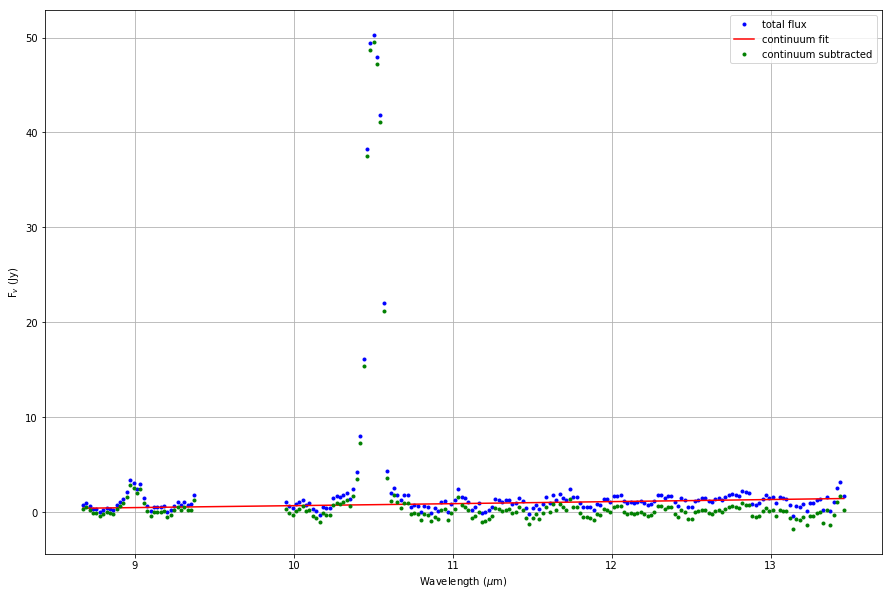

In [6]:
#now try it out with our G111 data:
fitContinuum(g111_clean,g111_cont)

#and plot model and continuum subtracted flux
plt.figure(figsize=(15,10))
plt.plot(g111_clean['wavelength'],g111_clean['flux'],'b.',label = "total flux")
plt.plot(g111_clean['wavelength'],g111_clean['cont'],color="r",label='continuum fit')
plt.plot(g111_clean['wavelength'],g111_clean['flux']-g111_clean['cont'],'g.',label='continuum subtracted')
plt.xlabel('Wavelength ($\mu$m)')
plt.ylabel('F$_v$ (Jy)')
plt.legend()
plt.grid()


Just for fun, lets fit the continuum of the accompanying G227 data, where the background is higher and more sloped.

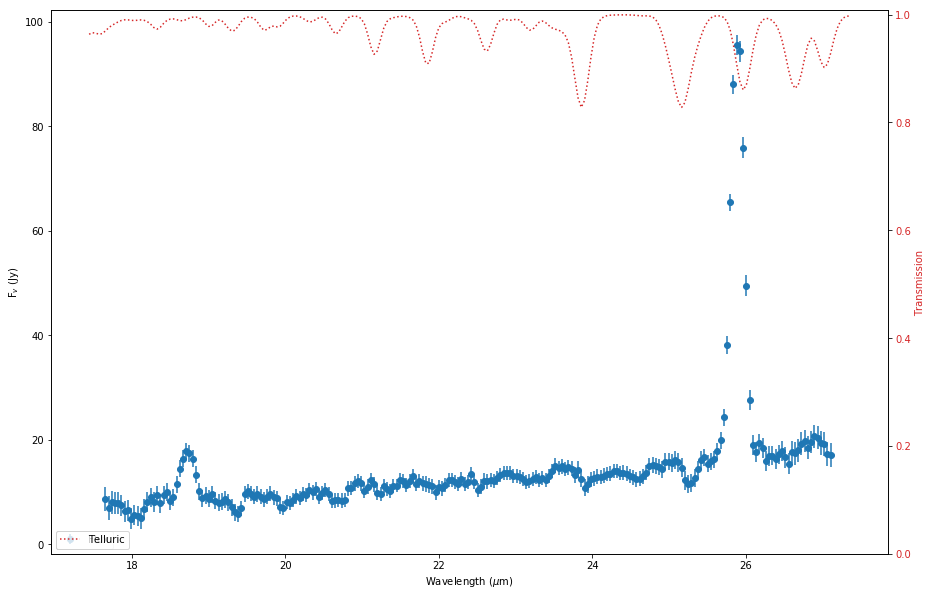

In [7]:
#Calibrated data file on local disk:
g227file = 'forcast-sample-data/F0428_FO_GRI_0500638_FORG227_CMB_0197-0215.fits'

#Load fits data and tabular data...
g227_fits, g227_tab=loadFORCASTGrismData(g227file)

#And plot flux and telluric spectra
fig, ax1 = plt.subplots(figsize=(15,10))

ax1.set_xlabel('Wavelength ($\mu$m)')
ax1.set_ylabel('F$_v$ (Jy)')
ax1.errorbar(g227_tab['wavelength'],g227_tab['flux'],yerr=g227_tab['error'],fmt='o',label="Flux")
ax1.legend(loc="lower left")

color = 'tab:red'
ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
ax2.set_ylabel('Transmission', color=color)
ax2.plot(g227_tab['wavelength'],g227_tab['telluric'], color=color, linestyle=':',label="Telluric")
ax2.tick_params(axis='y', labelcolor=color)
ax2.set_ylim(bottom=0.0)
ax2.legend()

It appears there are lines at about 18.8$\mu$m and 26$\mu$m; so define regions surrounding those lines and fit the continuum to the data outside those regions.

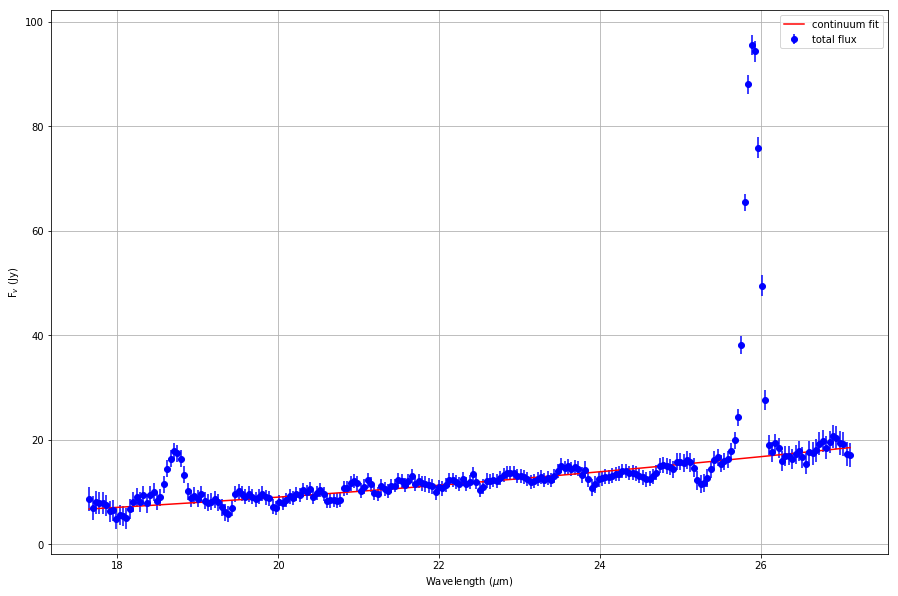

In [8]:
##Now clean  with a telluric threshold of 0.75
g227_clean = cleanFORCASTGrismData(g227_tab,0.75)

#Define the "line" regions
g227_line_regions = [[18.25*u.um,19.25*u.um], 
                [25.*u.um,26.5*u.um]]

#Create a continuum spectrum outside those line regions:
g227_cont = createContinuumSpectrum(g227_clean,g227_line_regions)

#and fit it with a second order Chebychev:
fitContinuum(g227_clean,g227_cont)

#and plot continuum fit
plt.figure(figsize=(15,10))
plt.errorbar(g227_clean['wavelength'],g227_clean['flux'],yerr=g227_clean['error'],
             fmt='o',color='b',label = "total flux")
plt.plot(g227_clean['wavelength'],g227_clean['cont'],color="r",label='continuum fit')
#plt.plot(g227_clean['wavelength'],g227_clean['flux']-g227_clean['cont'],'g.',label='continuum subtracted')
plt.xlabel('Wavelength ($\mu$m)')
plt.ylabel('F$_v$ (Jy)')
plt.legend()
plt.grid()


## Basic Line Measurements

The specutils package some with a number of convenient tools for quick line measurements. This recipe focuses on emission lines, but generally speaking the tools can be used with absorption lines as well.  For these examples we will want to use our continuum subtracted data.  We will also define subregions surrounding each line for further analysis.  REturning to the G111 grism data for the remainder of this recipe.

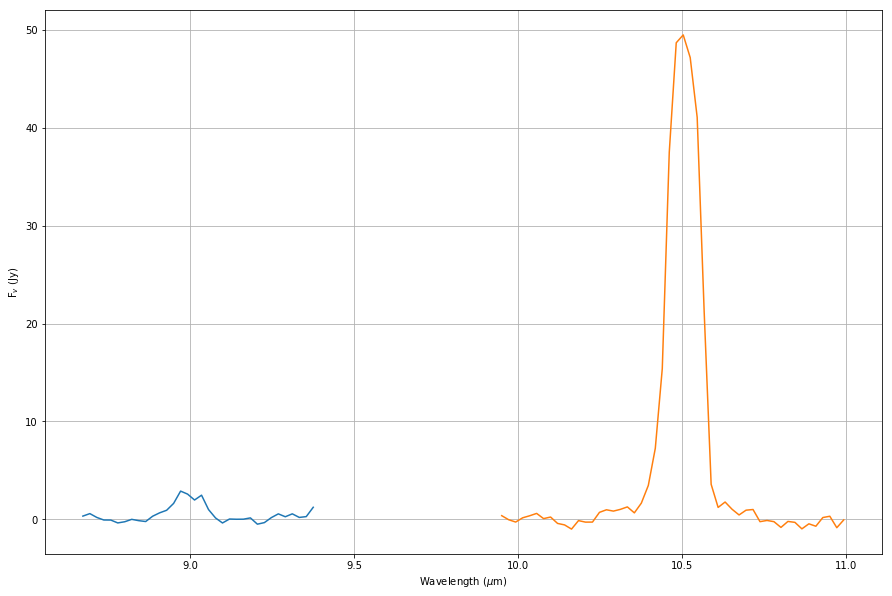

In [9]:
from specutils.manipulation import extract_region

#First read wavelength, flux, and continuum from our cleaned data table:
wave = g111_clean['wavelength']
flux = g111_clean['flux'] - g111_clean['cont']  #use continuum subtracted flux

#Now load into Spect1D object:
spec = Spectrum1D(spectral_axis=wave,flux=flux)

#Now define sub regions for each line, just eye-balling from the plot above.
lines_sr = SpectralRegion(8.5*u.um, 9.5*u.um) + SpectralRegion(9.5*u.um, 11.*u.um)

#And extract those regions for separate analysis.
#Extract_region takes a Spect1D and SpectralRegion objects as inputs and returns
#a *list* of Spect1D objects, one per region.  
lines = extract_region(spec, lines_sr)

#In this case we get *2* Spect1D objects in the list "lines".
#Plot them together:
plt.figure(figsize=(15,10))
for x in lines:
    plt.plot(x.spectral_axis,x.flux)
plt.xlabel('Wavelength ($\mu$m)')
plt.ylabel('F$_v$ (Jy)')
plt.grid()

Now we can use the estimate line parameters function to make some basic measurements for each line:

In [10]:
from specutils.fitting import estimate_line_parameters
from specutils.analysis import gaussian_sigma_width, gaussian_fwhm, fwhm

#In general, each of the analysis tools takes a Spect1D object along with additional, 
#sometimes optional, inputs and parameters.

#print out line parameters assuming 1D gaussian model
#estimate_line_parameters takes a Spect1D object as input with an optional model.
for x in lines:
    print(estimate_line_parameters(x, models.Gaussian1D()))

Model: Gaussian1D
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1
Parameters:
        amplitude            mean              stddev      
            Jy              micron             micron      
    ----------------- ----------------- -------------------
    2.877507609554206 9.035060779181816 0.10639572143554688
Model: Gaussian1D
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1
Parameters:
        amplitude            mean               stddev      
            Jy              micron              micron      
    ----------------- ------------------ -------------------
    49.49810765260474 10.495873599008922 0.10639572143554688


In [11]:
#and for those of us who prefer FWHM:
for x in lines:
    print(fwhm(x))

0.10639572143554688 micron
0.10639572143554688 micron


We can also compute the line flux for each line.  For convenience, we'll convert the Spec1D objects to frequency space to make the unit conversions easier.  Since line_flux is essentially just doing an integration over frequency for each line *region*, we can estimate the 1-$\sigma$ uncertainty of the line flux by simply adding the flux errors over the region in quadrature and multiplying by the wavelength step.  So now we will load the flux error spectrum into specutils, apply the regions, and then calculate the uncertainty for each region.

In [12]:
#convert spec1D objects to frequency space
#and reverse the arrays b/c apparently specutils expects spectral_axis to be increasing.
def toFrequency(specs):
    specs_nu=[]
    for x in specs:
        tmp=x.spectral_axis
        nu=tmp.to(u.THz,equivalencies=u.spectral())
        specs_nu.append(Spectrum1D(spectral_axis=nu[::-1],flux=x.flux[::-1]))
    return specs_nu

lines_nu=toFrequency(lines)

#Now get error spectrum....
wave = g111_clean['wavelength']
err = g111_clean['error']

#...and load into Spect1D object:
err_spec = Spectrum1D(spectral_axis=wave,flux=err)

#And extract the regions using regions defined above.
line_errs = extract_region(err_spec, lines_sr)

#ANd now use the line_flux function to get total line fluxes for each line.  
#line_flux takes a *continuum subtracted* Spectrum1D object with optional spectral region, if the
#user wants to integrate over a smaller region.
from specutils.analysis import line_flux

i = 0
while i < len(lines_nu):
    #print lineflux for each line region and convert to W/m^2
    x=lines_nu[i]
    print(x)
    print('Line Flux:')
    print(line_flux(x))
    print(line_flux(x).to(u.W * u.m**-2))
    
    
    #calculate the errors 
    errs = line_errs[i].flux
    quad = np.sqrt(np.sum(errs**2))
    
    #multiply by the step size in nu
    nu = lines_nu[i].spectral_axis
    del_nu = (np.max(nu) - np.min(nu))/(len(nu) - 1)
    line_flux_err = quad * del_nu
    print('Error:')
    print(line_flux_err)
    print(line_flux_err.to(u.W * u.m**-2))
    print('SNR:')
    print(line_flux(x)/line_flux_err)
    print('----------------------------')
    i += 1


Spectrum1D (length=34)
flux:             [ 1.2255 Jy, ..., 0.32276 Jy ],  mean=0.48871 Jy
spectral axis:    [ 31.979 THz, ..., 34.568 THz ],  mean=33.241 THz
Line Flux:
1.2077763452612775 Jy THz
1.2077763452612775e-14 W / m2
Error:
0.2570064956542103 Jy THz
2.570064956542103e-15 W / m2
SNR:
4.699400076199948
----------------------------
Spectrum1D (length=50)
flux:             [ -0.060154 Jy, ..., 0.36707 Jy ],  mean=5.6485 Jy
spectral axis:    [ 27.274 THz, ..., 30.132 THz ],  mean=28.656 THz
Line Flux:
16.325331982567114 Jy THz
1.6325331982567115e-13 W / m2
Error:
0.2786296592121553 Jy THz
2.7862965921215532e-15 W / m2
SNR:
58.59150827204872
----------------------------


## Line Fitting

Lastly, spectutils provides a nice set of tools for some basic line fitting.  Any of the models available in the astropy modelling package can be used.  The default fitter is a Levenberg-Marquardt algorithm for least squares (LevMarLSQFitter) although it appears other fitters could be used as well.  This section just gives an overview of the process for a single line (in our example, the strong one at 10.5$\mu$m).  Evaluating model parameter uncertainties is left to the user.  

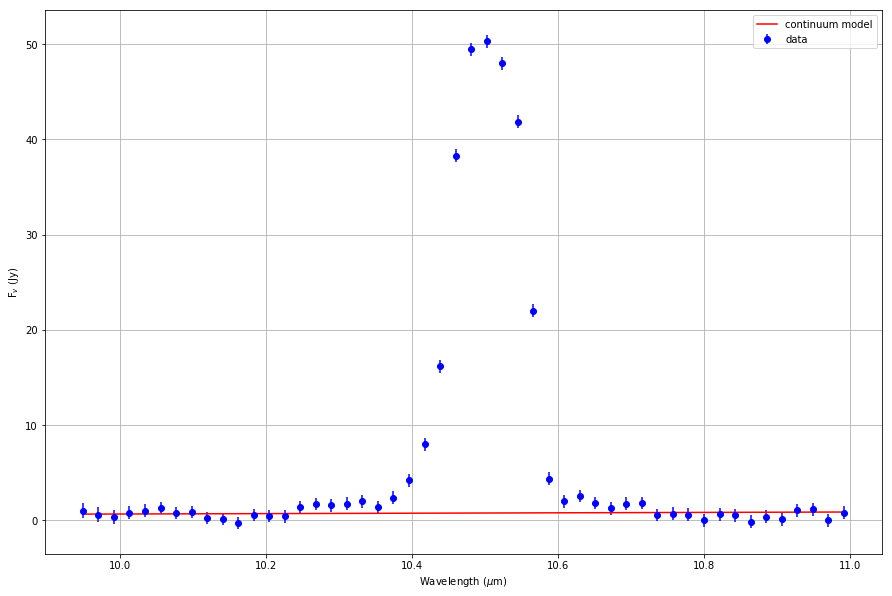

In [13]:
#First read wavelength, flux, and continuum from our cleaned data table:
wave = g111_clean['wavelength']
flux = g111_clean['flux']   #observed flux
err = g111_clean['error']   #errors
cont = g111_clean['cont']  #continuum model

#Now load into Spect1D objects:
spec_obs = Spectrum1D(spectral_axis=wave,flux=flux)
spec_cont = Spectrum1D(spectral_axis=wave,flux=cont)
spec_errs = Spectrum1D(spectral_axis=wave,flux=err)
spec_cs = Spectrum1D(spectral_axis=wave,flux=(flux-cont))  #we'll need continuum subtracted flux in the fitting step.

#Now define sub region for the line at 10.5 micron
line_sr = SpectralRegion(9.5*u.um, 11.*u.um)

#And extract that region for separate analysis.
#Extract_region takes a Spect1D and SpectralRegion objects as inputs and returns
line_obs = extract_region(spec_obs, line_sr)
line_cont = extract_region(spec_cont, line_sr)
line_err = extract_region(spec_errs, line_sr)
line_cs = extract_region(spec_cs, line_sr)   #continuum subtracted 


#Plot total flux and continuum model:
plt.figure(figsize=(15,10))
plt.errorbar(line_obs.spectral_axis,line_obs.flux,
             yerr=line_err.flux,fmt='o',color='b',label='data')
plt.plot(line_cont.spectral_axis,line_cont.flux,label='continuum model',color='red')
plt.xlabel('Wavelength ($\mu$m)')
plt.ylabel('F$_v$ (Jy)')
plt.grid()
plt.legend()

In [14]:
from specutils.fitting import fit_lines

#First generate an initial Gaussian profile model using estimates.
#Numerous other models (e.g. Voigt, Lorentzian, etc...) are available in the astropy modelling package.
g_est = estimate_line_parameters(line_cs, models.Gaussian1D())
#g_est = estimate_line_parameters(line_cs, models.Voigt1D())



#Regardless of what model is used, the fitting routine is the same.  
#fit_lines takes a Spect1D object as input as well as the initial model
g_fit = fit_lines(line_cs, g_est)

print(g_fit)

Model: Gaussian1D
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1
Parameters:
        amplitude            mean               stddev      
            Jy              micron              micron      
    ----------------- ------------------ -------------------
    53.86630544154305 10.503897442114619 0.04462751380476227


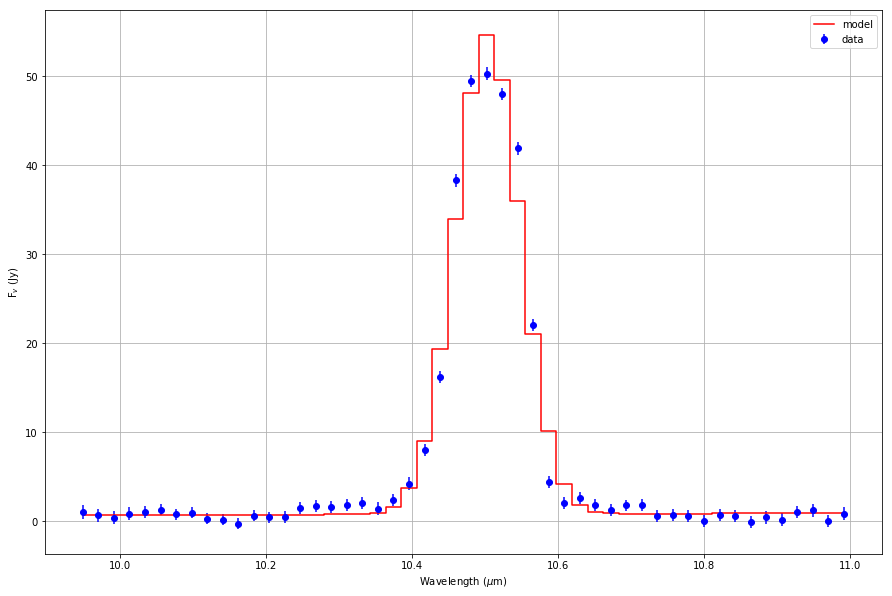

In [15]:
 #Calculate the model line flux and add to continuum model to generate full model:
model = g_fit(line_cs.spectral_axis) + line_cont.flux

#MOdel full model with observed flux
plt.figure(figsize=(15,10))
plt.errorbar(line_obs.spectral_axis,line_obs.flux,yerr=line_err.flux,fmt='o',color='b',label='data')
plt.step(line_obs.spectral_axis,model,label='model',color='red',where='mid')
plt.xlabel('Wavelength ($\mu$m)')
plt.ylabel('F$_v$ (Jy)')
plt.grid()
plt.legend()

A sigma of 0.045 $\mu$m corresponds to a FWHM of 0.106 $\mu$m and an R of ~100, which is close to the R = 130 limit for the G111 grism.  The line is either marginally resolved, or the image quality for this particular observation was not quite good enough to achieve the best possible resolution.  

We can evaluate the goodness of fit by examining the residuals and calculating the chi-squared and reduced chi-squared statistics.  For the degrees of freedom, remember that we used a 2nd order Chebyshez for our continuum, so we have *6* constraints for the full continuum and line model.

Chi Squared:
302.9874119260605
Reduced Chi Squared:
6.8860775437741015


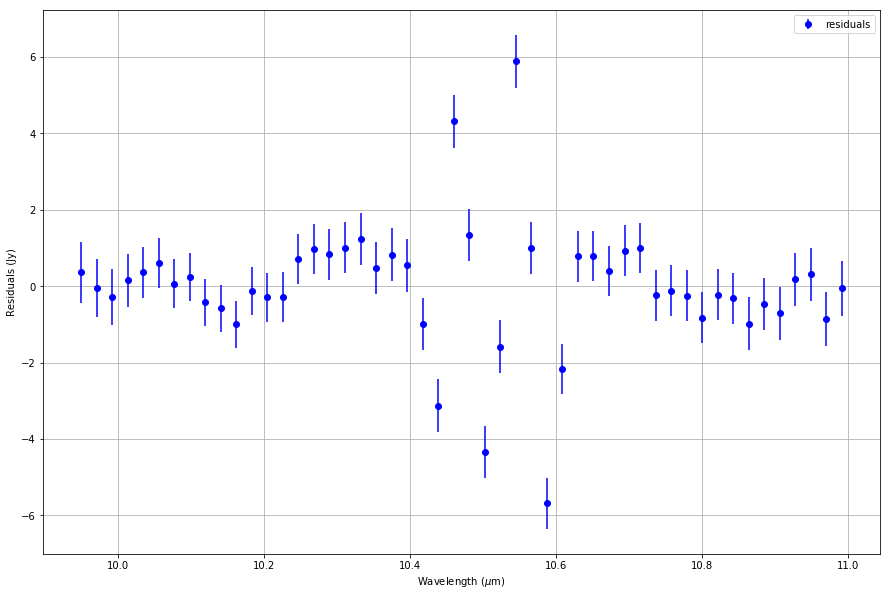

In [16]:
#Now calculate residuals:
res = line_obs.flux - model

#...and plot them.
plt.figure(figsize=(15,10))
x=lines[1]
err=line_errs[1]
plt.errorbar(x.spectral_axis,res,yerr=err.flux,fmt='o',color='b',label='residuals')
#plt.plot(x.spectral_axis,line_fit,label='line fit',color='red')
plt.xlabel('Wavelength ($\mu$m)')
plt.ylabel('Residuals (Jy)')
plt.grid()
plt.legend()

#Report the chi**2 statitic (for comparison to other model fits), and the reduced chi-squared:
c = 6  #nubmer of constraints (parameters) on our continuum + line model.
chisq=np.sum((res**2)/(line_err.flux)**2)
chisq_nu=chisq/(len(line_obs.flux)-c)
print('Chi Squared:')
print(chisq)
print('Reduced Chi Squared:')
print(chisq_nu)




So our simple Gaussian fit may suffice for centroid and and estimate of the FWHM, but is not a terribly good fit.

